# <img src="https://img.icons8.com/bubbles/100/000000/3d-glasses.png" style="height:50px;display:inline"> University of Haifa - Computer Vision


## Homework 1
---

### <a style='color:red'> Due Date: 11.06.2024 </a>

### <img src="https://img.icons8.com/bubbles/50/000000/checklist.png" style="height:50px;display:inline"> Agenda
---

* Recap on Python
* Excercise on triangle detection (scroll down to find it)

### <img src="https://img.icons8.com/bubbles/50/000000/information.png" style="height:50px;display:inline"> Student Information
---
**<font color='red'> FILL IN HERE</font>**:

|full name     |Email| ID  |
|---------|--------------------------------|----------|
|Student 1| student_1@| 112233445|
|Student 2| student_2@| 554433221|


### <img src="https://img.icons8.com/bubbles/50/000000/upload-to-cloud.png" style="height:50px;display:inline"> Submission Guidelines (IMPORTANT)
---
* Submission is in **pairs** (or singles, with special permission from lecturer).
* Fill in your details in the cell above.
* Submit **this file only**, with the name: `CV_hw1_id1_id2.ipynb`.
* Make sure to submit the file **after execution** (including all outputs). Cells that were not executed will be ignored by the grader.
* Submit on the course website (Moodle).
* Due date is Tuesday, June 11 2024 (end of the day).
* Late submission will be open till Friday, June 14 2024, with 4 points deduction for each late day.

### <img src="https://img.icons8.com/clouds/96/000000/keyboard.png" style="height:50px;display:inline"> Useful Keyboard Shortcuts
---
* Run current cell: **Ctrl + Enter**
* Run current cell and move to the next: **Shift + Enter**
* Show lines in a code cell: **Esc + L**
* View function documentation: **Shift + Tab** inside the parenthesis or `help(name_of_module)`
* New cell below: **Esc + B**
* Delete cell: **Esc + D, D** (two D's)

### Useful imports
---

In [ ]:
# imports for the tutorial - YOU MAY ADD MORE IF NEEDED
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow

### <img src="https://img.icons8.com/dusk/64/000000/python.png" style="height:50px;display:inline"> Recap on Python
---

## <img src="https://img.icons8.com/clouds/100/000000/calculator.png" style="height:50px;display:inline"> NumPy
---

### Arrays


In [ ]:
''' 1D Lists and 2D Matrices as NumPy Arrays'''
print('-- 1D Lists and 2D Matrices as NumPy Arrays --')

vec = [1, 2, 3] # list
np_vec = np.array(vec) # array
print("type(np_vec) = ", type(np_vec)) # check the type
print("np_vec = ", np_vec) # print the array
mat = [[2, 6, 8], [3, 7, 0]] # 2d list
np_mat = np.array(mat) # 2d ndarray
print("np.array(mat) = ")
print(np_mat) # print the matrix


-- 1D Lists and 2D Matrices as NumPy Arrays --
type(np_vec) =  <class 'numpy.ndarray'>
np_vec =  [1 2 3]
np.array(mat) = 
[[2 6 8]
 [3 7 0]]


#### Zeros, Ones, Eye

In [ ]:
''' Zeros, Ones, Eye'''
print('-- Zeros, Ones, Eye --')

# zeros, ones and identity - just like matlab
print("np.zeros((2,3)) = ")
print(np.zeros((2,3)))
print("np.ones((2,3)) = ")
print(np.ones((2,3)))
print("np.eye(2) = ")
print(np.eye(2))

-- Zeros, Ones, Eye --
np.zeros((2,3)) = 
[[0. 0. 0.]
 [0. 0. 0.]]
np.ones((2,3)) = 
[[1. 1. 1.]
 [1. 1. 1.]]
np.eye(2) = 
[[1. 0.]
 [0. 1.]]


### Random
#### Create Random Arrays and Numbers with NumPy

In [ ]:
''' Randomness'''
print('-- Randomness --')

print('np.random.randn(5) = ', np.random.randn(5)) # 5x1 array with numbers from N(0,1)
print('np.random.randn(3,4) = ')
print(np.random.randn(3,4)) # 3x4 matrix with numbers from N(0,1)
print('np.random.randint(5, 15) = ', np.random.randint(5, 15)) # random integer between start (5) and end (15)
print('np.random.randint(5, 150, 5) = ', np.random.randint(5, 150, 5)) # multiple (5) random numbers between specified range


-- Randomness --
np.random.randn(5) =  [-0.45203119  1.23818497 -0.79519291  0.01308439  0.04596214]
np.random.randn(3,4) = 
[[-0.34557184 -0.22875176  0.76922493  0.31366312]
 [-0.68849259 -0.0213819   1.090488   -0.63953912]
 [ 0.81152254 -1.88560627 -0.55754914  0.39217135]]
np.random.randint(5, 15) =  13
np.random.randint(5, 150, 5) =  [ 86  82  83 133  44]


### Series of Numbers


In [ ]:
''' Series of Numbers'''
print('-- Series of Numbers --')

print('np.arange(3, 12) = ', np.arange(3, 12)) # 3, 4..., 11
print('np.arange(3, 12, 2) = ', np.arange(3, 12, 2)) # with a step of 2
print('np.linspace(2, 5, 6) = ', np.linspace(2, 5, 6)) # third argument specifies the count of numbers
print('np.linspace(2, 5) = ', np.linspace(2, 5)) # as in matlab default count is 50 -- third argument


-- Series of Numbers --
np.arange(3, 12) =  [ 3  4  5  6  7  8  9 10 11]
np.arange(3, 12, 2) =  [ 3  5  7  9 11]
np.linspace(2, 5, 6) =  [2.  2.6 3.2 3.8 4.4 5. ]
np.linspace(2, 5) =  [2.         2.06122449 2.12244898 2.18367347 2.24489796 2.30612245
 2.36734694 2.42857143 2.48979592 2.55102041 2.6122449  2.67346939
 2.73469388 2.79591837 2.85714286 2.91836735 2.97959184 3.04081633
 3.10204082 3.16326531 3.2244898  3.28571429 3.34693878 3.40816327
 3.46938776 3.53061224 3.59183673 3.65306122 3.71428571 3.7755102
 3.83673469 3.89795918 3.95918367 4.02040816 4.08163265 4.14285714
 4.20408163 4.26530612 4.32653061 4.3877551  4.44897959 4.51020408
 4.57142857 4.63265306 4.69387755 4.75510204 4.81632653 4.87755102
 4.93877551 5.        ]


### Operations on arrays


In [ ]:
''' On Arrays '''
print('-- On Arrays --')

np_vec = np.array([1, 2, 3]) # array
np_mat = np.array([[2, 6, 8], [3, 7, 0]]) # 2d ndarray
# dimensions of arrays
print('np_mat = ')
print(np_mat)
print('np_vec.shape = ', np_vec.shape)
print('np_mat.shape = ', np_mat.shape)
# reshape
print('np_mat.reshape(3,2) = ') # change dimensions -- only if the total number of values remains the same
print(np_mat.reshape(3,2)) # change dimensions -- only if the total number of values remains the same
# maximum, minimum, sum, mean, ...
print("sin(np_mat) = ", np.sin(np_mat)) # sin() of each element, same dimensions
print("sum(np_mat) = ", np.sum(np_mat)) # sum of all elements
print("min(np_mat) = ", np.min(np_mat)) # min of the entire array
print("mean(np_mat) = ", np.mean(np_mat,0)) # mean over first dimension
print("max(np_mat) = ", np.max(np_mat,1)) # max over second dimension

-- On Arrays --
np_mat = 
[[2 6 8]
 [3 7 0]]
np_vec.shape =  (3,)
np_mat.shape =  (2, 3)
np_mat.reshape(3,2) = 
[[2 6]
 [8 3]
 [7 0]]
sin(np_mat) =  [[ 0.90929743 -0.2794155   0.98935825]
 [ 0.14112001  0.6569866   0.        ]]
sum(np_mat) =  26
min(np_mat) =  0
mean(np_mat) =  [2.5 6.5 4. ]
max(np_mat) =  [8 7]


### Operations between arrays and scalars

In [ ]:
''' Arrays and Scalars '''
print('-- Arrays and Scalars --')

a = np.array([0, 1, 2, 3, 4, 5])
print("a = ", a)
print("a + 7 = ", a + 7) # add 7 to each element
print("a - 2 = ", a - 2)
print("a / 2 = ", a / 2)
print("a * 3 = ", a * 3)
print("a = ", a ) # element-wise comparison
print("a > 2 = ", a > 2) # element-wise comparison

-- Arrays and Scalars --
a =  [0 1 2 3 4 5]
a + 7 =  [ 7  8  9 10 11 12]
a - 2 =  [-2 -1  0  1  2  3]
a / 2 =  [0.  0.5 1.  1.5 2.  2.5]
a * 3 =  [ 0  3  6  9 12 15]
a =  [0 1 2 3 4 5]
a > 2 =  [False False False  True  True  True]


In [ ]:
''' Arrays and Arrays '''
print('-- Arrays and Arrays --')

a1 = np.array([[3, 1], [2, 6]])
print("a1 = ")
print(a1)
b1 = np.array([[0, 2], [3, 1]])
print("b1 = ")
print(b1)
print("a1 + b1 = ")
print(a1 + b1)
print("a1 * b1 = ")
print(a1 * b1) # element-wise multiplication
print("np.dot(a1, b1) = ")
print(np.dot(a1, b1)) # matrix multiplication
print("a1 @ b1 = ")
print(a1 @ b1) # matrix multiplication
print("(np.dot(a1, b1) is the same as using @: a1 @ b1)") # matrix multiplication
print("a1 > b1 = ")
print(a1 > b1) # element-wise comparison

-- Arrays and Arrays --
a1 = 
[[3 1]
 [2 6]]
b1 = 
[[0 2]
 [3 1]]
a1 + b1 = 
[[3 3]
 [5 7]]
a1 * b1 = 
[[0 2]
 [6 6]]
np.dot(a1, b1) = 
[[ 3  7]
 [18 10]]
a1 @ b1 = 
[[ 3  7]
 [18 10]]
(np.dot(a1, b1) is the same as using @: a1 @ b1)
a1 > b1 = 
[[ True False]
 [False  True]]


### Indexing, Slicing, Broadcasting

In [ ]:
''' Indexing, Slicing, Broadcasting '''
print('-- Indexing, Slicing, Broadcasting --')

d1 = np.arange(15)
print('d1 = ', d1)
d2 = d1.reshape(3,5)
print('d2 = ')
print(d2)
# slicing
d1[4:12] # slicing -- d1[start : end+1]
print("d1[4:12] = ", d1[6:9])
print("d1[4: ] = ", d1[6: ])
print("d1[:13] = ", d1[:9])
print("d2[0,0] = ", d2[0,0]) # d2[row, column]
print("d2[1,] = ", d2[2,])
print("d2[:, 2]", d2[:, 3])
d1[0:5] = -10 # broadcasting -- Change specific elements of the array
print("d1 = ", d1)

-- Indexing, Slicing, Broadcasting --
d1 =  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
d2 = 
[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]]
d1[4:12] =  [6 7 8]
d1[4: ] =  [ 6  7  8  9 10 11 12 13 14]
d1[:13] =  [0 1 2 3 4 5 6 7 8]
d2[0,0] =  0
d2[1,] =  [10 11 12 13 14]
d2[:, 2] [ 3  8 13]
d1 =  [-10 -10 -10 -10 -10   5   6   7   8   9  10  11  12  13  14]


## <img src="https://img.icons8.com/dusk/64/000000/area-chart.png" style="height:50px;display:inline"> Matplotlib
---

### Plotting



-- Indexing, Slicing, Broadcasting --


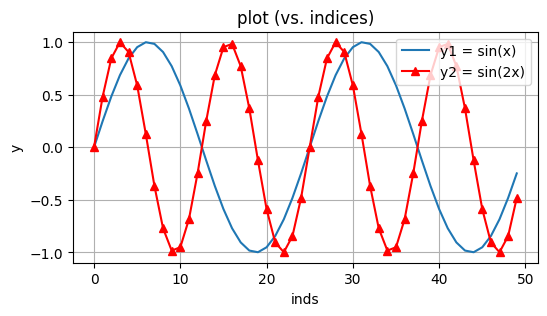

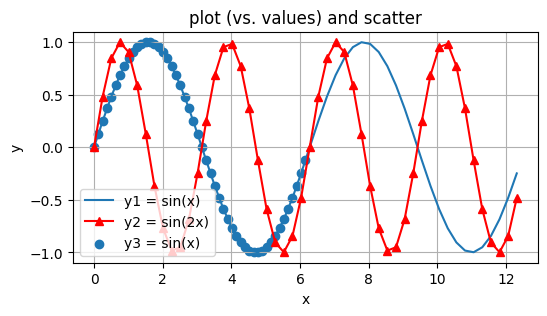

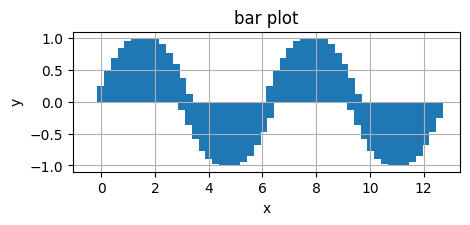

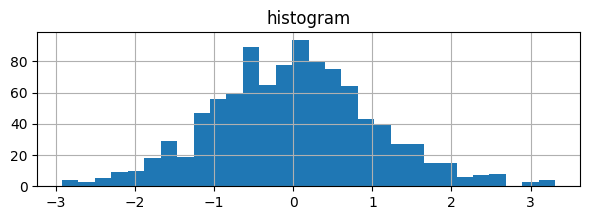

In [ ]:
### Plotting

''' Indexing, Slicing, Broadcasting '''
print('-- Indexing, Slicing, Broadcasting --')

# plot agains indices
x = np.arange(50) * 2 * np.pi / 25
y1 = np.sin(x)
y2 = np.sin(2*x)
y3 = np.cos(x)
fig = plt.figure(figsize=(6,3)) # create a figure, just like in matlab
ax = fig.add_subplot(1, 1 ,1) # create a subplot of certain size
ax.plot(y1, label="y1 = sin(x)")
ax.plot(y2, 'r-^', label="y2 = sin(2x)")
ax.set_xlabel('inds')
ax.set_ylabel("y")
ax.set_title("plot (vs. indices)")
ax.grid()
ax.legend()

# plot against values and scatter
x = np.arange(50) * 2 * np.pi / 25
x2 = x/2
y1 = np.sin(x)
y2 = np.sin(2*x)
y3 = np.sin(x2)
fig = plt.figure(figsize=(6,3)) # create a figure, just like in matlab
ax = fig.add_subplot(1, 1 ,1) # create a subplot of certain size
ax.plot(x, y1, label="y1 = sin(x)")
ax.plot(x, y2, 'r-^', label="y2 = sin(2x)")
ax.scatter(x2, y3, label="y3 = sin(x)") # notice the x/2
ax.set_xlabel('x')
ax.set_ylabel("y")
ax.set_title("plot (vs. values) and scatter")
ax.grid()
ax.legend()

# bar-plot
fig = plt.figure(figsize=(5, 4)) # create a figure, just like in matlab
ax1 = fig.add_subplot(2, 1 ,1) # create a subplot of certain size
ax1.bar(x, y1)
ax1.set_xlabel('x')
ax1.set_ylabel("y")
ax1.set_title("bar plot")
ax1.grid()

# histogram
fig = plt.figure(figsize=(7,2)) # create a figure, just like in matlab
ax = fig.add_subplot(1, 1 ,1) # create a subplot of certain size
ax.hist(np.random.randn(1000), 30) # 30 is the number of bins
ax.set_title("histogram")
ax.grid()

### images - reading, overlays and saving

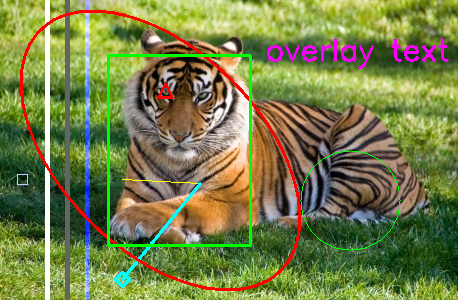

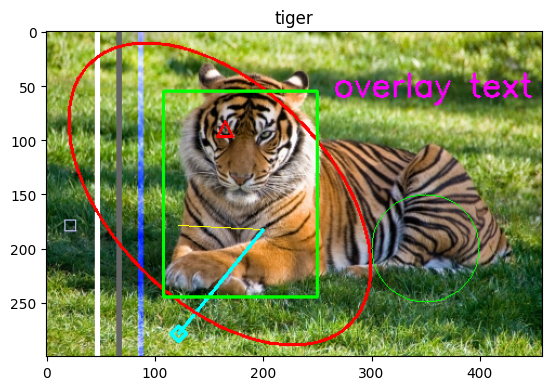

In [ ]:
# Read image
image = cv2.imread('tiger.jpg')

# Manual overlays
image[:,45:50,:] = 255  # all white
image[:,65:70,:] = [100,100,100] # all grey
image[:,85:90,0] = 255  # change blue channel only

# Other overlays
cv2.line(image, (122, 179), (200, 183), (0, 255, 255), thickness=1)
cv2.line(image, (122, 279), (200, 183), (255, 255, 0), thickness=2)
cv2.drawMarker(image, (122, 279), (255, 255, 0), markerSize = 15, thickness=2, markerType=cv2.MARKER_DIAMOND)
cv2.drawMarker(image, (22, 179), (255, 200, 200), markerSize = 10, thickness=1, markerType=cv2.MARKER_SQUARE)
cv2.drawMarker(image, (165, 90), (0, 0, 255), markerSize = 15, thickness=2, markerType=cv2.MARKER_TRIANGLE_UP)
cv2.ellipse(image, (160, 150), (100, 170), 135, 0, 360, (0, 0, 255), thickness=2)
cv2.rectangle(image, (108, 55), (250, 245), (0, 255, 0), thickness=2, lineType=cv2.LINE_8)
cv2.putText(image, "overlay text", (265, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (250, 0, 250), 2)
cv2.circle(image, (350, 200), 50, (0, 255, 0), thickness=1)

# show with cv2
cv2_imshow(image) # show with cv2

# show with pyplot
plt.imshow(image[:,:,::-1]) # notice the need to reverse the channel order (cv2 uses BGR while plt uses RGB)
plt.title('tiger')

# save/write
cv2.imwrite('tiger_cv2.jpg',image)
image = image[:,:,::-1] # flip channels
plt.imsave('tiger_plt.jpg',image)


### <img src="https://img.icons8.com/office/80/000000/edit-image.png" style="height:50px;display:inline"> **Exercise: Hough Triangles**
---
In this part, we are going to implement detectors for particular types of triangles: 1) **Equilateral** triangles - ones that have 3 equal sides (and 3 equal angles); 2) **Isosceles** triangles - Ones with two sides of equal length (and equal base angles); 3) **Right** triangles - ones that have a 90 degree angle;

We are going to do so based on the processing of the standard Hough Transform (HT) Map that is used for detecting lines (with the $\theta, d$ parameterization). See the following cell evaluation for a full illustrative example.

Submit outputs on **4 input images** of your choice: Choose one from each group (folder) of images provided.


**Recommendations**:
* You can tune the parameters (like edge detection thresholds, HT resolution) of your solution seperately per input image. However, the method should be generic and run on all the input images without any manual interventions (other than parameter changes).
* You can use the 'sliding-window' HT variant that we discussed in class. That is, you can run the HT on a sliding $r\times r$ window, with skips of size $s$ (both vertical and horizontal). You are allowed to choose the sizes $r$ and $s$ manually per image (by determining the maximal size of a triangle to detect).
* To improve the detected lines (maxima in HT) you should aim to improve the edge map and apply some kind of suprression on the HT-map (e.g. filter out lines that are too close in some senses, lines that have weak support, etc').

**Output format** (per input image):

1. Input image
2. Edge map
3. Hough transform (one per window with triangle detection, if using sliding window) - Should include marking of all detected lines by small square markers, with the color-coding of blue/green/red for equilateral/isosceles/right triangle sides.
4. Detected lines (one per window with triangle detection, if using sliding window) - Shown over the edge map.
5. Detected triangles - Shown by taking the edge map and coloring every edge point that belongs to a triangle by its color-coding specified above.

**Guidelines**:
* Run the next cell to see an example (that doesn't use a sliding window).
* Write your code in the cell that follows (You may add as many cells as you want).
* You may use existing code (from cv2 or any other library) for loading, displaying, overlaying, saving images as well as for edge-detection and other standard image filtering operations.
* You must provide **your own implementation** of the line Hough Transform. Make sure that your code is properly commented.
* The very last cell of your code should generate the outputs for each of the images.
* The very last cell of this notebook (after your code and output images) is where you should explain your solution according to the guidelines given there.

### **An example**
---

Text(0.5, 1.0, 'detected triangles (color-coded)')

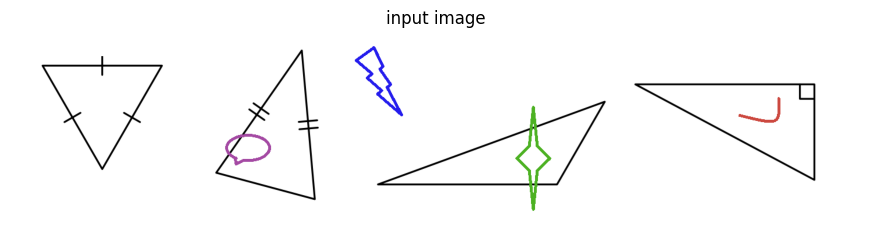

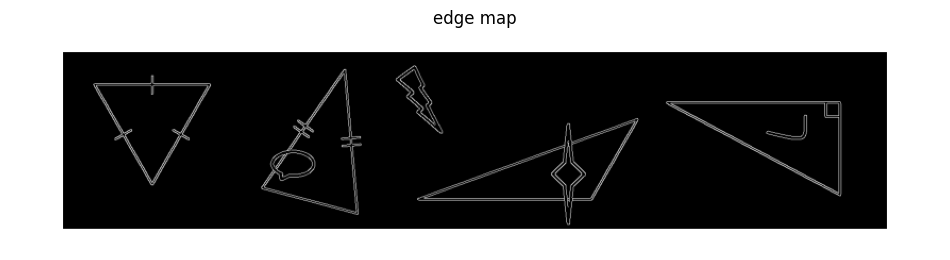

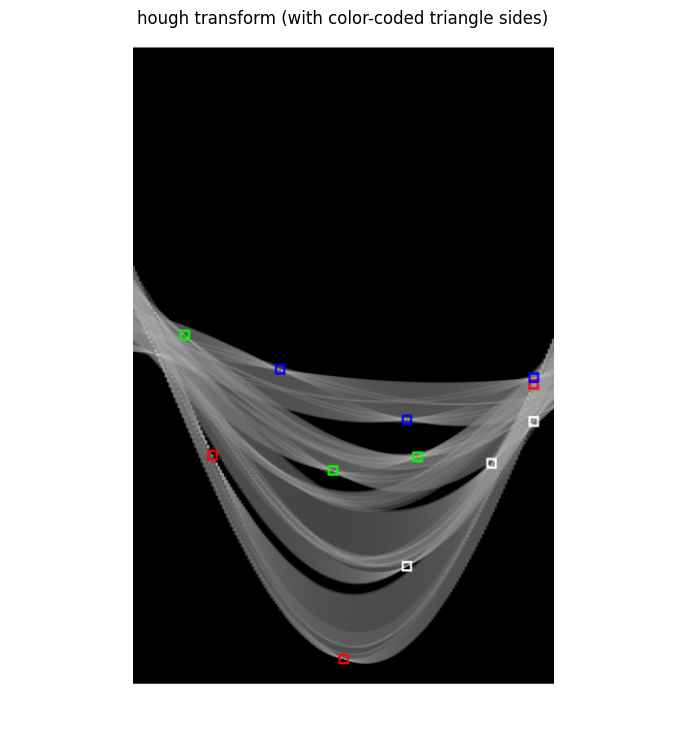

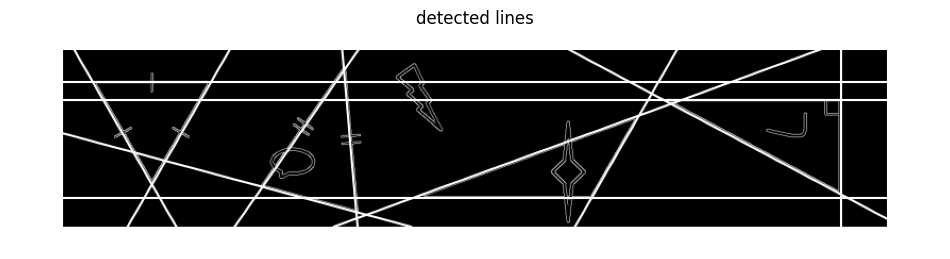

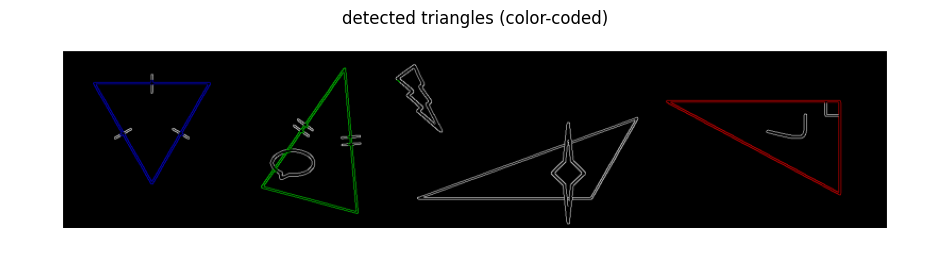

In [36]:
# Example input and outputs
input = cv2.imread('four_triangles_example.png')
edge_map = cv2.imread('edge_map.png')
hough_transform = cv2.imread('hough_transform.png')
detected_lines = cv2.imread('detected_lines.png')
detected_triangles = cv2.imread('detected_triangles.png')

plt.figure(figsize=(11,11),dpi=100) #####################################################
plt.imshow(input)
plt.axis('off')
plt.title('input image')
plt.figure(figsize=(12,12),dpi=100) #####################################################
plt.imshow(edge_map)
plt.axis('off')
plt.title('edge map')
plt.figure(figsize=(9,9),dpi=100) #####################################################
plt.imshow(hough_transform)
plt.axis('off')
plt.title('hough transform (with color-coded triangle sides)')
plt.figure(figsize=(12,12),dpi=100) #####################################################
plt.imshow(detected_lines)
plt.axis('off')
plt.title('detected lines')
plt.figure(figsize=(12,12),dpi=100) #####################################################
plt.imshow(detected_triangles)
plt.axis('off')
plt.title('detected triangles (color-coded)')

### **Your code**
---
Write your code (that must be commented and executed before submission) in the following cells.
You may use as many text or code cells that you need.

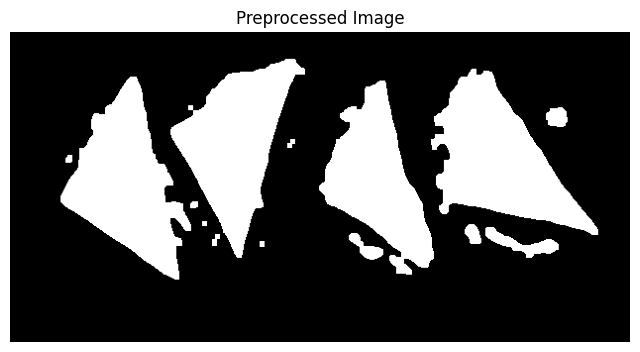

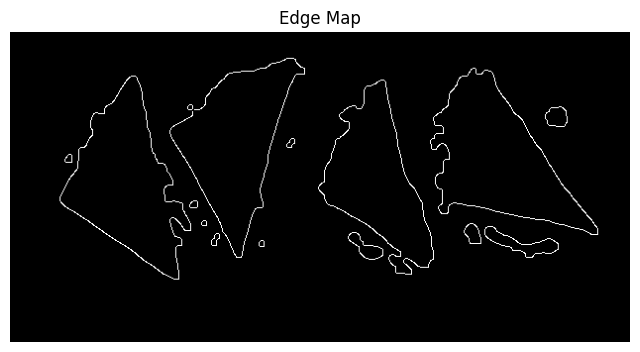

C:\Users\alexc\AppData\Local\Temp\ipykernel_22780\442144534.py:91: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(np.round(x0)), int(np.round(y0))


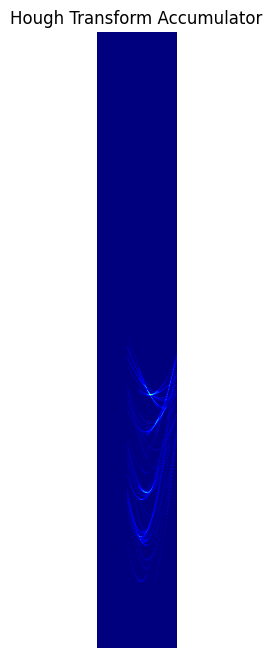

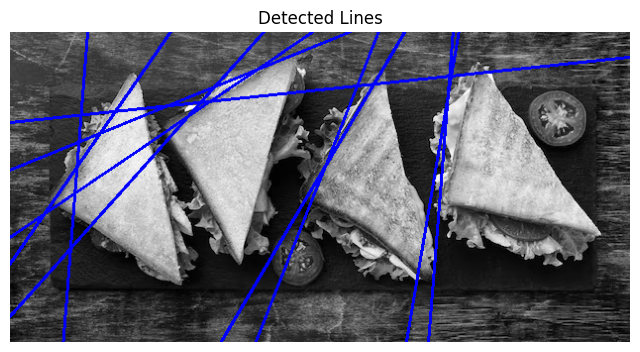

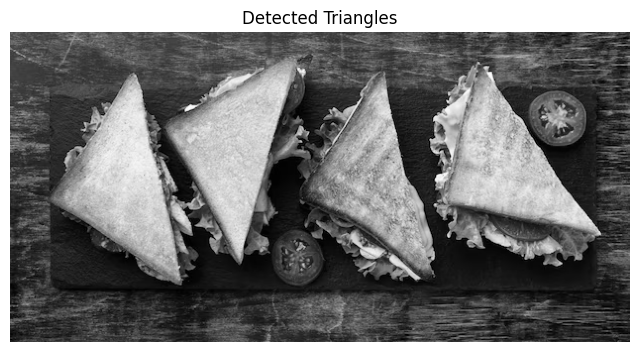

In [63]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

def display_image(title, img, cmap='gray'):
    plt.figure(figsize=(8, 8))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

def preprocess_image(image):
    bilateral_filtered = cv2.bilateralFilter(image, d=13, sigmaColor=75, sigmaSpace=75)
    blurred = cv2.GaussianBlur(bilateral_filtered, (5, 5), 0)
    _, binary = cv2.threshold(blurred, 50, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((3, 3), np.uint8)
    opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel, iterations=2)
    return closed

def compute_gradients(image):
    grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    magnitude = cv2.magnitude(grad_x, grad_y)
    direction = cv2.phase(grad_x, grad_y, angleInDegrees=True)
    return magnitude, direction

def hough_transform(edge_map, direction, rho_res, theta_res, threshold):
    height, width = edge_map.shape
    max_rho = int(np.sqrt(height**2 + width**2))
    rhos = np.linspace(-max_rho, max_rho, int(2 * max_rho / rho_res))
    thetas = np.linspace(-np.pi / 2, np.pi / 2, int(np.pi / theta_res))
    accumulator = np.zeros((len(rhos), len(thetas)))

    edge_points = np.argwhere(edge_map)
    for y, x in edge_points:
        edge_dir = np.deg2rad(direction[y, x])
        for t_index, theta in enumerate(thetas):
            if np.abs(edge_dir - theta) < np.pi / 8:
                rho = int(x * np.cos(theta) + y * np.sin(theta))
                rho_index = np.argmin(np.abs(rhos - rho))
                accumulator[rho_index, t_index] += 1

    lines = []
    for rho_index in range(len(rhos)):
        for theta_index in range(len(thetas)):
            if accumulator[rho_index, theta_index] >= threshold:
                rho = rhos[rho_index]
                theta = thetas[theta_index]
                lines.append((rho, theta))
    
    return lines, accumulator

def non_maximum_suppression(lines, distance_threshold, angle_threshold):
    suppressed_lines = []
    for i, (rho1, theta1) in enumerate(lines):
        is_suppressed = False
        for j in range(i + 1, len(lines)):
            rho2, theta2 = lines[j]
            if abs(rho1 - rho2) < distance_threshold and abs(theta1 - theta2) < angle_threshold:
                is_suppressed = True
                break
        if not is_suppressed:
            suppressed_lines.append((rho1, theta1))
    return suppressed_lines

def draw_lines(image, lines, color=(255, 0, 0)):
    img = np.copy(image)
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    for rho, theta in lines:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(img, (x1, y1), (x2, y2), color, 2)
    return img

def intersection(line1, line2):
    rho1, theta1 = line1
    rho2, theta2 = line2
    A = np.array([[np.cos(theta1), np.sin(theta1)], [np.cos(theta2), np.sin(theta2)]])
    b = np.array([[rho1], [rho2]])
    if np.linalg.det(A) != 0:
        x0, y0 = np.linalg.solve(A, b)
        return int(np.round(x0)), int(np.round(y0))
    else:
        return None

def angle_between_lines(line1, line2):
    _, theta1 = line1
    _, theta2 = line2
    angle = np.abs(np.rad2deg(theta1 - theta2))
    if angle > 180:
        angle = 360 - angle
    return angle

def classify_triangle_by_angles(angles):
    angles = sorted(angles)
    if np.isclose(angles[0], angles[1]) and np.isclose(angles[1], angles[2]):
        return "Equilateral"
    elif np.isclose(angles[0], angles[1]) or np.isclose(angles[1], angles[2]) or np.isclose(angles[0], angles[2]):
        if any(np.isclose(angle, 90) for angle in angles):
            return "Right Isosceles"
        return "Isosceles"
    elif any(np.isclose(angle, 90) for angle in angles):
        return "Right"
    else:
        return None

def draw_triangles(image, triangles):
    img = np.copy(image)
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    for triangle in triangles:
        pts = np.array(triangle[1], np.int32).reshape((-1, 1, 2))
        cv2.polylines(img, [pts], isClosed=True, color=(0, 255, 0), thickness=2)
    return img

def detect_triangles(lines, img_shape, angle_threshold_degrees):
    triangles = []
    for comb in combinations(lines, 3):
        angles = []
        points = []
        for i in range(3):
            line1 = comb[i]
            line2 = comb[(i + 1) % 3]
            angle = angle_between_lines(line1, line2)
            angles.append(angle)
            inter = intersection(line1, line2)
            if inter is not None:
                points.append(inter)
        
        if len(points) == 3:
            triangle_type = classify_triangle_by_angles(angles)
            if triangle_type:
                triangles.append((triangle_type, points))
    return triangles

def process_image(image_path):
    try:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            raise ValueError(f"Failed to load image at path: {image_path}")
    except Exception as e:
        print(f"Error: {e}")
        return

    preprocessed = preprocess_image(image)
    display_image("Preprocessed Image", preprocessed)

    magnitude, direction = compute_gradients(preprocessed)
    edges = cv2.Canny(preprocessed, 50, 150)
    display_image("Edge Map", edges)

    lines, accumulator = hough_transform(edges, direction, rho_res=1, theta_res=np.pi / 180, threshold=20)
    lines = non_maximum_suppression(lines, distance_threshold=20, angle_threshold=np.pi / 36)

    angle_threshold_degrees = 10
    triangles = detect_triangles(lines, image.shape, angle_threshold_degrees)

    display_image("Hough Transform Accumulator", accumulator, cmap='jet')
    image_with_lines = draw_lines(image, lines, color=(0, 0, 255))
    display_image("Detected Lines", image_with_lines)
    
    image_with_triangles = draw_triangles(image, triangles)
    display_image("Detected Triangles", image_with_triangles)
#image_path = 'Assets/group_flags/flags2.jpg'  # replace with the actual path to the uploaded image
#process_image(image_path)
image_path = 'Assets/group_natural/top-view-triangle-sandwiches-slate-with-tomatoes_23-2148640143.png'
process_image(image_path)





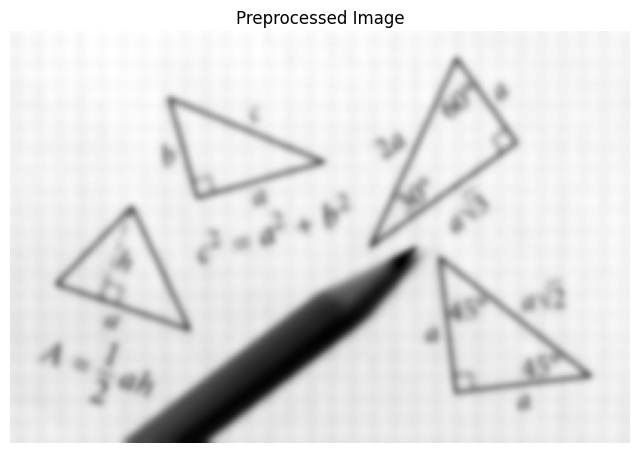

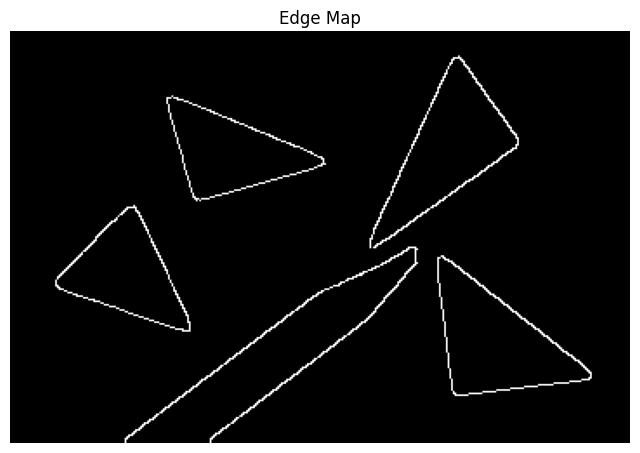

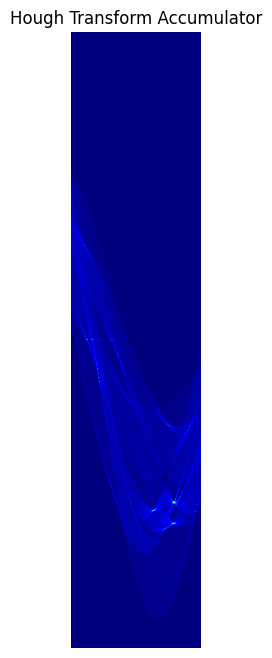

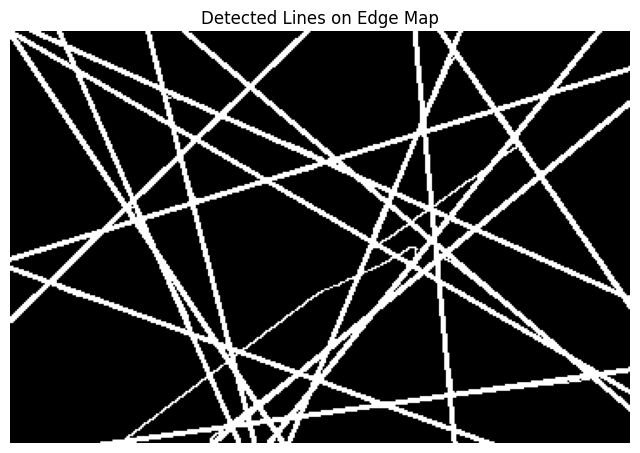

In [228]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def display_image(title, img, cmap='gray'):
    plt.figure(figsize=(8, 8))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

def preprocess_image(image, d, sigmaColor, sigmaSpace, blur_ksize):
    bilateral_filtered = cv2.bilateralFilter(image, d=d, sigmaColor=sigmaColor, sigmaSpace=sigmaSpace)
    blurred = cv2.GaussianBlur(bilateral_filtered, (blur_ksize, blur_ksize), 0)
    return blurred

def hough_transform(edge_map, rho_res, theta_res, threshold):
    height, width = edge_map.shape
    max_rho = int(np.sqrt(height**2 + width**2))
    rhos = np.linspace(-max_rho, max_rho, int(2 * max_rho / rho_res))
    thetas = np.linspace(-np.pi / 2, np.pi / 2, int(np.pi / theta_res))
    accumulator = np.zeros((len(rhos), len(thetas)))

    edge_points = np.argwhere(edge_map)
    for y, x in edge_points:
        for t_index, theta in enumerate(thetas):
            rho = int(x * np.cos(theta) + y * np.sin(theta))
            rho_index = np.argmin(np.abs(rhos - rho))
            accumulator[rho_index, t_index] += 1

    lines = []
    for rho_index in range(len(rhos)):
        for theta_index in range(len(thetas)):
            if accumulator[rho_index, theta_index] >= threshold:
                rho = rhos[rho_index]
                theta = thetas[theta_index]
                lines.append((rho, theta))
    
    return lines, accumulator

def non_maximum_suppression(lines, distance_threshold, angle_threshold):
    suppressed_lines = []
    for i, (rho1, theta1) in enumerate(lines):
        is_suppressed = False
        for j in range(i + 1, len(lines)):
            rho2, theta2 = lines[j]
            if abs(rho1 - rho2) < distance_threshold and abs(theta1 - theta2) < angle_threshold:
                is_suppressed = True
                break
        if not is_suppressed:
            suppressed_lines.append((rho1, theta1))
    return suppressed_lines

def draw_lines_on_edge_map(edge_map, lines, color=(255, 255, 255)):
    img = np.copy(edge_map)
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    for rho, theta in lines:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(img, (x1, y1), (x2, y2), color, 2)
    return img

def process_image(image_path, preprocess_params, hough_params, nms_params):
    try:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            raise ValueError(f"Failed to load image at path: {image_path}")
    except Exception as e:
        print(f"Error: {e}")
        return

    preprocessed = preprocess_image(image, **preprocess_params)
    display_image("Preprocessed Image", preprocessed)

    edges = cv2.Canny(preprocessed, 100, 200)

    # Apply morphological operations to remove small noises
    #kernel = np.ones((5, 5), np.uint8)
    #edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=1)
    display_image("Edge Map", edges)

    lines, accumulator = hough_transform(edges, **hough_params)
    lines = non_maximum_suppression(lines, **nms_params)

    display_image("Hough Transform Accumulator", accumulator, cmap='jet')
    edges_with_lines = draw_lines_on_edge_map(edges, lines, color=(255, 255, 255))
    display_image("Detected Lines on Edge Map", edges_with_lines)

# Parameters for the first image
image_path1 = 'Assets/group_natural/top-view-triangle-sandwiches-slate-with-tomatoes_23-2148640143.png'
preprocess_params1 = {'d': 9, 'sigmaColor': 75, 'sigmaSpace': 75, 'blur_ksize': 5}
hough_params1 = {'rho_res': 1, 'theta_res': np.pi / 180, 'threshold': 50}
nms_params1 = {'distance_threshold': 30, 'angle_threshold': np.pi / 18}

# Parameters for the second image
image_path2 = 'Assets/group_sketch/several-triangles.jpg'
preprocess_params2 = {'d': 9, 'sigmaColor': 80, 'sigmaSpace': 50, 'blur_ksize': 9}
hough_params2 = {'rho_res': 1, 'theta_res': np.pi / 180, 'threshold': 40}
nms_params2 = {'distance_threshold': 50, 'angle_threshold': np.pi / 36}

#process_image(image_path1, preprocess_params1, hough_params1, nms_params1)
process_image(image_path2, preprocess_params2, hough_params2, nms_params2)


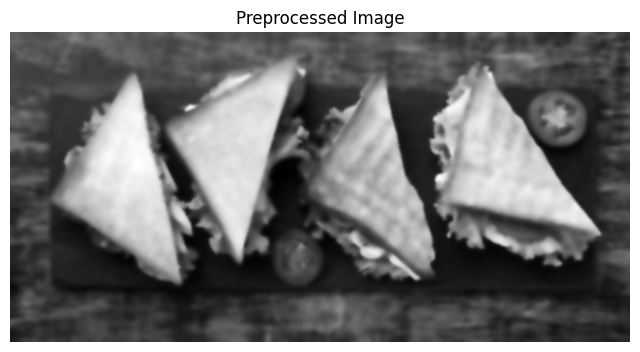

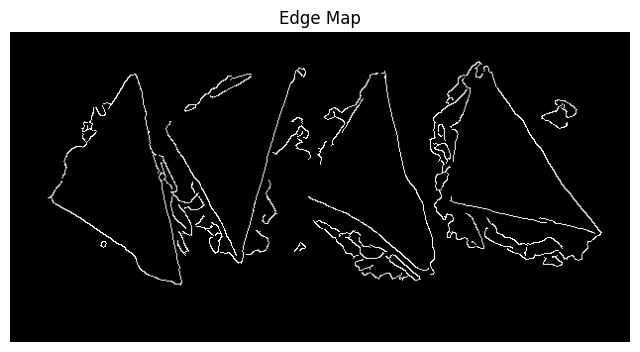

[]


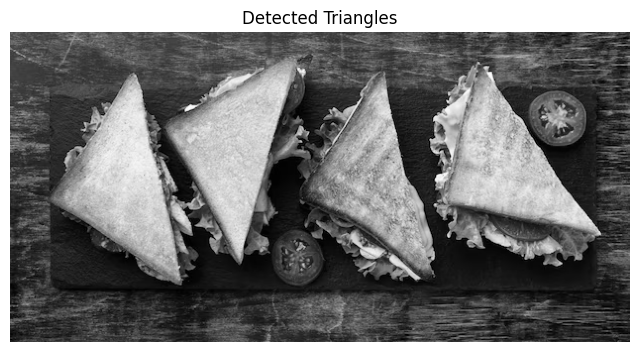

In [354]:
#input_image_path = 'Assets/four_triangles_example.png'
import cv2
import numpy as np
import matplotlib.pyplot as plt

def display_image(title, img, cmap='gray'):
    plt.figure(figsize=(8, 8))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

def preprocess_image(image, d, sigmaColor, sigmaSpace, blur_ksize):
    bilateral_filtered = cv2.bilateralFilter(image, d=d, sigmaColor=sigmaColor, sigmaSpace=sigmaSpace)
    blurred = cv2.GaussianBlur(bilateral_filtered, (blur_ksize, blur_ksize), 0)
    return blurred

def hough_transform(edge_map, rho_res, theta_res, threshold):
    height, width = edge_map.shape
    max_rho = int(np.sqrt(height**2 + width**2))
    rhos = np.linspace(-max_rho, max_rho, int(2 * max_rho / rho_res))
    thetas = np.linspace(-np.pi / 2, np.pi / 2, int(np.pi / theta_res))
    accumulator = np.zeros((len(rhos), len(thetas)))

    edge_points = np.argwhere(edge_map)
    for y, x in edge_points:
        for t_index, theta in enumerate(thetas):
            rho = int(x * np.cos(theta) + y * np.sin(theta))
            rho_index = np.argmin(np.abs(rhos - rho))
            accumulator[rho_index, t_index] += 1

    lines = []
    for rho_index in range(len(rhos)):
        for theta_index in range(len(thetas)):
            if accumulator[rho_index, theta_index] >= threshold:
                rho = rhos[rho_index]
                theta = thetas[theta_index]
                lines.append((rho, theta))
    
    return lines, accumulator

def non_maximum_suppression(lines, distance_threshold, angle_threshold):
    suppressed_lines = []
    for i, (rho1, theta1) in enumerate(lines):
        is_suppressed = False
        for j in range(i + 1, len(lines)):
            rho2, theta2 = lines[j]
            if abs(rho1 - rho2) < distance_threshold and abs(theta1 - theta2) < angle_threshold:
                is_suppressed = True
                break
        if not is_suppressed:
            suppressed_lines.append((rho1, theta1))
    return suppressed_lines

def triangle_edge_check(edge_map, pt1, pt2, pt3, threshold=0.05):
    height, width = edge_map.shape
    
    def edge_presence(ptA, ptB):
        x_values = np.linspace(ptA[0], ptB[0], num=100).astype(int)
        y_values = np.linspace(ptA[1], ptB[1], num=100).astype(int)
        # Ensure the indices are within the image bounds
        valid_indices = (x_values >= 0) & (x_values < width) & (y_values >= 0) & (y_values < height)
        x_values = x_values[valid_indices]
        y_values = y_values[valid_indices]
        if len(x_values) == 0 or len(y_values) == 0:
            return 0
        return np.sum(edge_map[y_values, x_values] != 0) / len(x_values)

    edge1 = edge_presence(pt1, pt2)
    edge2 = edge_presence(pt2, pt3)
    edge3 = edge_presence(pt3, pt1)
    
    return (edge1 + edge2 + edge3) / 3 > threshold

def classify_triangle(pt1, pt2, pt3):
    def length(ptA, ptB):
        return np.sqrt((ptA[0] - ptB[0]) ** 2 + (ptA[1] - ptB[1]) ** 2)
    
    len1 = length(pt1, pt2)
    len2 = length(pt2, pt3)
    len3 = length(pt3, pt1)
    
    # Check for equilateral triangle
    if np.isclose(len1, len2, atol=10) and np.isclose(len2, len3, atol=10):
        return "equilateral"
    
    # Check for isosceles triangle
    if np.isclose(len1, len2, atol=10) or np.isclose(len2, len3, atol=10) or np.isclose(len3, len1, atol=10):
        return "isosceles"
    
    # Check for right triangle
    def angle(ptA, ptB, ptC):
        ba = np.array(ptA) - np.array(ptB)
        bc = np.array(ptC) - np.array(ptB)
        cos_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
        angle = np.arccos(cos_angle)
        return np.degrees(angle)
    
    angle1 = angle(pt1, pt2, pt3)
    angle2 = angle(pt2, pt3, pt1)
    angle3 = angle(pt3, pt1, pt2)
    
    if np.isclose(angle1, 90, atol=10) or np.isclose(angle2, 90, atol=10) or np.isclose(angle3, 90, atol=10):
        return "right"
    
    return None

def detect_triangles(image_path, preprocess_params, hough_params, nms_params, edge_threshold=0.05):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    preprocessed = preprocess_image(image, **preprocess_params)
    display_image("Preprocessed Image", preprocessed)

    edges = cv2.Canny(preprocessed, 50, 200)
    display_image("Edge Map", edges)

    lines, accumulator = hough_transform(edges, **hough_params)
    accumulator = np.log10(accumulator)
    lines = non_maximum_suppression(lines, **nms_params)

    display_image("Hough Transform Accumulator", accumulator, cmap='jet')
    edges_with_lines = draw_lines_on_edge_map(edges, lines, color=(255, 255, 255))
    display_image("Detected Lines on Edge Map", edges_with_lines)

    triangles = []
    for i in range(len(lines)):
        for j in range(i + 1, len(lines)):
            for k in range(j + 1, len(lines)):
                pt1 = intersection(lines[i], lines[j])
                pt2 = intersection(lines[j], lines[k])
                pt3 = intersection(lines[k], lines[i])
                if pt1 and pt2 and pt3:
                    if triangle_edge_check(edges, pt1, pt2, pt3, edge_threshold):
                        triangle_type = classify_triangle(pt1, pt2, pt3)
                        if triangle_type:
                            triangles.append((triangle_type, [pt1, pt2, pt3]))

    print(triangles)

    def is_within_bounds(point, height, width):
        x, y = point
        return 0 <= x < width and 0 <= y < height

    img_with_triangles = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    height, width = img_with_triangles.shape[:2]
    for triangle_type, triangle in triangles:
        if all(is_within_bounds(pt, height, width) for pt in triangle):
            pts = np.array(triangle, np.int32)
            pts = pts.reshape((-1, 1, 2))
            if triangle_type == "equilateral":
                color = (255, 0, 0)  # Blue
            elif triangle_type == "isosceles":
                color = (0, 255, 0)  # Green
            elif triangle_type == "right":
                color = (0, 0, 255)  # Red
            cv2.polylines(img_with_triangles, [pts], isClosed=True, color=color, thickness=2)
    
    display_image("Detected Triangles", img_with_triangles)

def intersection(line1, line2):
    rho1, theta1 = line1
    rho2, theta2 = line2
    A = np.array([[np.cos(theta1), np.sin(theta1)], [np.cos(theta2), np.sin(theta2)]])
    b = np.array([rho1, rho2])
    if np.linalg.det(A) == 0:
        return None  # Lines are parallel
    x, y = np.linalg.solve(A, b)
    return int(x), int(y)

# Example usage
image_path1 = 'Assets/group_natural/top-view-triangle-sandwiches-slate-with-tomatoes_23-2148640143.png'
preprocess_params1 = {'d': 9, 'sigmaColor': 75, 'sigmaSpace': 75, 'blur_ksize': 5}
hough_params1 = {'rho_res': 1, 'theta_res': np.pi / 180, 'threshold': 50}
nms_params1 = {'distance_threshold': 30, 'angle_threshold': np.pi / 18}

detect_triangles(image_path1, preprocess_params1, hough_params1, nms_params1, edge_threshold=0.05)


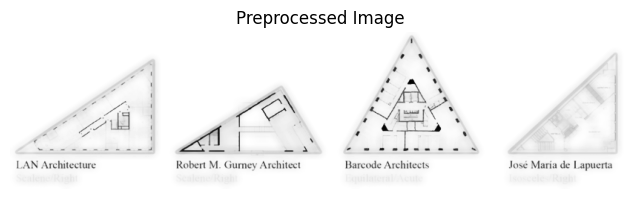

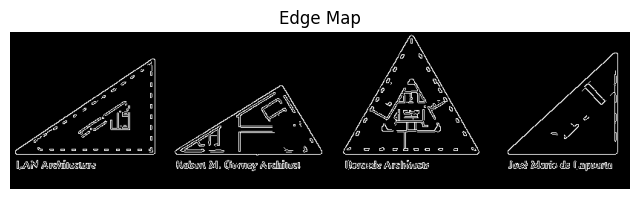

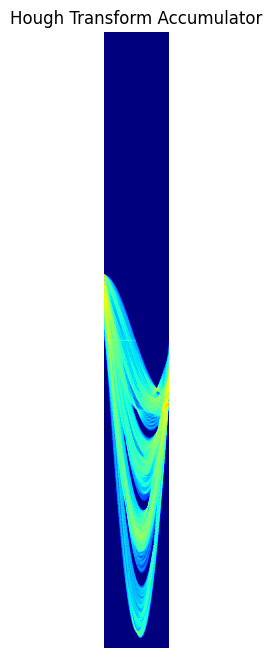

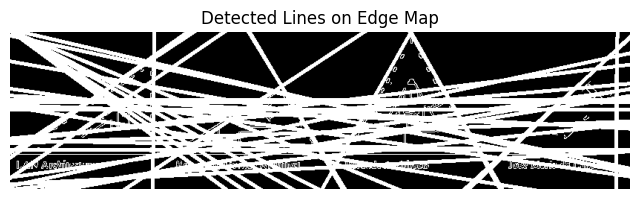

[]


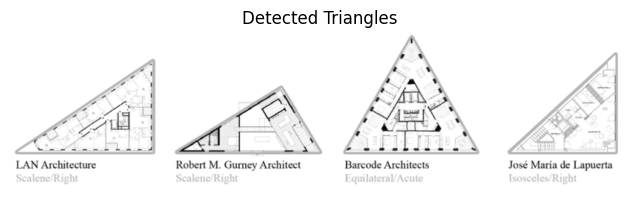

In [473]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def display_image(title, img, cmap='gray'):
    plt.figure(figsize=(8, 8))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

def preprocess_image(image, d, sigmaColor, sigmaSpace, blur_ksize):
    bilateral_filtered = cv2.bilateralFilter(image, d=d, sigmaColor=sigmaColor, sigmaSpace=sigmaSpace)
    blurred = cv2.GaussianBlur(bilateral_filtered, (blur_ksize, blur_ksize), 0)
    return blurred

def hough_transform(edge_map, rho_res, theta_res, threshold):
    height, width = edge_map.shape
    max_rho = int(np.sqrt(height**2 + width**2))
    rhos = np.linspace(-max_rho, max_rho, int(2 * max_rho / rho_res))
    thetas = np.linspace(-np.pi / 2, np.pi / 2, int(np.pi / theta_res))
    accumulator = np.zeros((len(rhos), len(thetas)))

    edge_points = np.argwhere(edge_map)
    for y, x in edge_points:
        for t_index, theta in enumerate(thetas):
            rho = int(x * np.cos(theta) + y * np.sin(theta))
            rho_index = np.argmin(np.abs(rhos - rho))
            accumulator[rho_index, t_index] += 1

    lines = []
    for rho_index in range(len(rhos)):
        for theta_index in range(len(thetas)):
            if accumulator[rho_index, theta_index] >= threshold:
                rho = rhos[rho_index]
                theta = thetas[theta_index]
                lines.append((rho, theta))
    
    return lines, accumulator

def non_maximum_suppression(lines, distance_threshold, angle_threshold):
    suppressed_lines = []
    for i, (rho1, theta1) in enumerate(lines):
        is_suppressed = False
        for j in range(i + 1, len(lines)):
            rho2, theta2 = lines[j]
            if abs(rho1 - rho2) < distance_threshold and abs(theta1 - theta2) < angle_threshold:
                is_suppressed = True
                break
        if not is_suppressed:
            suppressed_lines.append((rho1, theta1))
    return suppressed_lines

def triangle_edge_check(edge_map, pt1, pt2, pt3, threshold=0.01):
    height, width = edge_map.shape
    
    def edge_presence(ptA, ptB):
        x_values = np.linspace(ptA[0], ptB[0], num=100).astype(int)
        y_values = np.linspace(ptA[1], ptB[1], num=100).astype(int)
        # Ensure the indices are within the image bounds
        valid_indices = (x_values >= 0) & (x_values < width) & (y_values >= 0) & (y_values < height)
        x_values = x_values[valid_indices]
        y_values = y_values[valid_indices]
        if len(x_values) == 0 or len(y_values) == 0:
            return 0
        return np.sum(edge_map[y_values, x_values] != 0) / len(x_values)

    edge1 = edge_presence(pt1, pt2)
    edge2 = edge_presence(pt2, pt3)
    edge3 = edge_presence(pt3, pt1)
    
    
    return (edge1 + edge2 + edge3) / 3 > threshold

def classify_triangle(pt1, pt2, pt3):
    def length(ptA, ptB):
        return np.sqrt((ptA[0] - ptB[0]) ** 2 + (ptA[1] - ptB[1]) ** 2)
    
    len1 = length(pt1, pt2)
    len2 = length(pt2, pt3)
    len3 = length(pt3, pt1)
    
    # Check for equilateral triangle
    if np.isclose(len1, len2, atol=10) and np.isclose(len2, len3, atol=10):
        return "equilateral"
    
    # Check for isosceles triangle
    if np.isclose(len1, len2, atol=10) or np.isclose(len2, len3, atol=10) or np.isclose(len3, len1, atol=10):
        return "isosceles"
    
    # Check for right triangle
    def angle(ptA, ptB, ptC):
        ba = np.array(ptA) - np.array(ptB)
        bc = np.array(ptC) - np.array(ptB)
        cos_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
        angle = np.arccos(cos_angle)
        return np.degrees(angle)
    
    angle1 = angle(pt1, pt2, pt3)
    angle2 = angle(pt2, pt3, pt1)
    angle3 = angle(pt3, pt1, pt2)
    
    if np.isclose(angle1, 90, atol=10) or np.isclose(angle2, 90, atol=10) or np.isclose(angle3, 90, atol=10):
        return "right"
    
    return None

def plot_hough_transform(window, accumulator, lines, window_number):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    ax[0].imshow(window, cmap='gray')
    ax[0].set_title(f'Window {window_number}')
    
    ax[1].imshow(accumulator, cmap='hot')
    ax[1].set_title(f'Hough Transform Accumulator for Window {window_number}')
    
    for line in lines:
        rho, theta = line
        x = np.linspace(0, window.shape[1], 1000)
        y = (rho - x * np.cos(theta)) / np.sin(theta)
        ax[0].plot(x, y, '-r')
    
    plt.show()




def detect_triangles(image_path, preprocess_params, hough_params, nms_params, window_size, edge_threshold=0.1):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    preprocessed = preprocess_image(image, **preprocess_params)
    display_image("Preprocessed Image", preprocessed)

    edges = cv2.Canny(preprocessed, 70, 150)
    display_image("Edge Map", edges)

    height, width = edges.shape
    step_size = window_size // 2
    triangles = []  # Initialize the list of triangles

    window_number = 0

    for y in range(0, height - window_size, step_size):
        for x in range(0, width - window_size, step_size):
            window = edges[y:y + window_size, x:x + window_size]
            if np.sum(window) == 0:
                continue  # Skip windows without edges

            lines, accumulator = hough_transform(window, **hough_params)
            accumulator = np.log10(accumulator + 1)  # log10 for plotting
            lines = non_maximum_suppression(lines, **nms_params)
            #print('hi')
            #plot_hough_transform(window, accumulator, lines, window_number)
            window_number += 1

            #print(lines)

            for i in range(len(lines)):
                for j in range(i + 1, len(lines)):
                    for k in range(j + 1, len(lines)):
                        pt1 = intersection(lines[i], lines[j])
                        pt2 = intersection(lines[j], lines[k])
                        pt3 = intersection(lines[k], lines[i])
                        if pt1 and pt2 and pt3:
                            #print('hi')
                            pt1 = (pt1[0] + x, pt1[1] + y)
                            pt2 = (pt2[0] + x, pt2[1] + y)
                            pt3 = (pt3[0] + x, pt3[1] + y)
                            if triangle_edge_check(edges, pt1, pt2, pt3, edge_threshold):
                                triangle_type = classify_triangle(pt1, pt2, pt3)
                                if triangle_type:
                                    triangles.append((triangle_type, [pt1, pt2, pt3]))

    lines, accumulator = hough_transform(edges, **hough_params)
    accumulator = np.log10(accumulator + 1)  # log10 for plotting
    lines = non_maximum_suppression(lines, **nms_params)

    display_image("Hough Transform Accumulator", accumulator, cmap='jet')
    edges_with_lines = draw_lines_on_edge_map(edges, lines, color=(255, 255, 255))
    display_image("Detected Lines on Edge Map", edges_with_lines)

    print(triangles)

    def is_within_bounds(point, height, width):
        x, y = point
        return 0 <= x < width and 0 <= y < height

    img_with_triangles = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    height, width = img_with_triangles.shape[:2]
    for triangle_type, triangle in triangles:
        if all(is_within_bounds(pt, height, width) for pt in triangle):
            pts = np.array(triangle, np.int32)
            pts = pts.reshape((-1, 1, 2))
            if triangle_type == "equilateral":
                color = (255, 0, 0)  # Blue
            elif triangle_type == "isosceles":
                color = (0, 255, 0)  # Green
            elif triangle_type == "right":
                color = (0, 0, 255)  # Red
            cv2.polylines(img_with_triangles, [pts], isClosed=True, color=color, thickness=2)
    
    display_image("Detected Triangles", img_with_triangles)

def intersection(line1, line2):
    rho1, theta1 = line1
    rho2, theta2 = line2
    A = np.array([[np.cos(theta1), np.sin(theta1)], [np.cos(theta2), np.sin(theta2)]])
    b = np.array([rho1, rho2])
    if np.linalg.det(A) == 0:
        return None  # Lines are parallel
    x, y = np.linalg.solve(A, b)
    return int(x), int(y)

def draw_lines_on_edge_map(edge_map, lines, color=(255, 255, 255)):
    img_with_lines = cv2.cvtColor(edge_map, cv2.COLOR_GRAY2BGR)
    for rho, theta in lines:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(img_with_lines, (x1, y1), (x2, y2), color, 3)
    return img_with_lines

# Example usage
image_path1 = 'Assets/group_natural/top-view-triangle-sandwiches-slate-with-tomatoes_23-2148640143.png'
preprocess_params1 = {'d': 5, 'sigmaColor': 75, 'sigmaSpace': 75, 'blur_ksize': 3}
hough_params1 = {'rho_res': 1, 'theta_res': np.pi / 180, 'threshold': 50}
nms_params1 = {'distance_threshold': 30, 'angle_threshold': np.pi / 18}
window_size1 = 300  # Adjust the window size as needed

#detect_triangles(image_path1, preprocess_params1, hough_params1, nms_params1, window_size1, edge_threshold=0.1)


image_path2 = 'Assets/group_sketch/sample_triangles.png'
preprocess_params2 = {'d': 19, 'sigmaColor': 50, 'sigmaSpace': 100, 'blur_ksize': 1}
hough_params2 = {'rho_res': 1, 'theta_res': np.pi / 180, 'threshold': 70}
nms_params2 = {'distance_threshold': 5, 'angle_threshold': np.pi / 96}
window_size2 = 280  # Adjust the window size as needed

detect_triangles(image_path2, preprocess_params2, hough_params2, nms_params2, window_size2, edge_threshold=0.1)


your text

In [ ]:
# your code...

In [ ]:
# your code...

### **Explanation of your solution** (fill in here)
---

1) Explain in short detail the stages of your solution

1. xxx
2. xxx
3. xxx
4. ...

2) Explain some problems/difficulties that you encountered and what you did to overcome them.
1. xxx
2. xxx
3. ..

3) Specify and explain in short some limitations of your approach (You may refer to the results in any of the output images).
1. xxx
2. ..

